# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>
**scipy.stats**: Box-Cox transformation.

In [1]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
from scipy.stats import boxcox
import os

# Getting the data

Navigate to the root of the repo

In [2]:
os.chdir('../..')

Getting the data from GCP bucket,

In [3]:
# Uncomment the code below to download data from GCP
# !mkdir data/mini_sample -p
# !gsutil -q cp -r 'gs://deepfwi-mini-sample/*' data/mini_sample

Sample of files we just fetched,

In [4]:
files = glob('data/mini_sample/fwi-reanalysis/*')
files[:4]

['data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191206_1200_hr_fwi_e5.nc',
 'data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191213_1200_hr_fwi_e5.nc',
 'data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191214_1200_hr_fwi_e5.nc',
 'data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191203_1200_hr_fwi_e5.nc']

# Overview

Combining multiple files into single dataarray.

In [5]:
data = xr.open_mfdataset(files).sortby("time").load()

Taking a look.

In [6]:
print(data)

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 19)
Coordinates:
  * lon      (lon) float32 0.0 0.28125 0.5625 ... 359.15625 359.4375 359.71875
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * time     (time) datetime64[ns] 2019-12-01 2019-12-02 ... 2019-12-19
Data variables:
    fwi      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Wed Jun 03 12:12:14 2020: cdo --silent -select,name=fw...
    Reference date:    20191206
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...


**Pixel resolution**: *640x1280*<br>
**Longitude resolution**: 0.28125<br>
**Latitude resolution**: 0.278674<br>

Time span of the data,

In [7]:
d_range = [str(v.astype('datetime64[D]')) for v in data.time.values]
f"From {d_range[0]} to {d_range[-1]}"

'From 2019-12-01 to 2019-12-19'

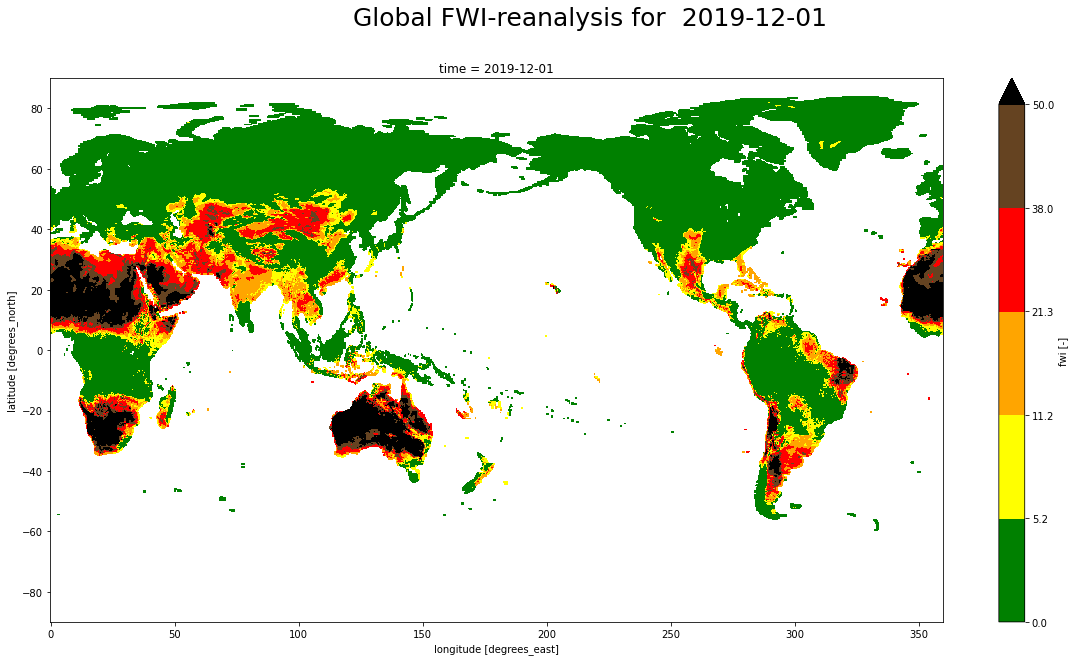

In [8]:
plt.figure(figsize = (20,10)).suptitle(f"Global FWI-reanalysis for  {d_range[0]}", fontsize=25)
data.fwi[0].plot(levels = [0.0, 5.2, 11.2, 21.3, 38.0, 50.0],
                 colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
                 label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'])

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [9]:
np.isnan(data.fwi[0].values).any()

True

## Overall statistics

During the statistics calculation, the NaN values are skipped.

In [10]:
def npstats(x):
    # For numpy matrices
    tmp = np.nanmean(x)
    print('Mean'.ljust(10), tmp)
    print('MAD'.ljust(10), np.nanmean(np.abs(x-tmp)))
    print('Variance'.ljust(10), np.nanvar(x))
    print('Minimum'.ljust(10), np.nanmin(x))
    print('Maximum'.ljust(10), np.nanmax(x))    

In [11]:
def stats(x):
    # For xarray matrices
    tmp = x.mean(skipna=True).values
    print('Mean'.ljust(10), tmp)
    print('MAD'.ljust(10), abs(x-tmp).mean(skipna=True).values)
    print('Variance'.ljust(10), x.var(skipna=True).values)
    print('Minimum'.ljust(10), x.min(skipna=True).values)
    print('Maximum'.ljust(10), x.max(skipna=True).values)

In [12]:
stats(data.fwi)

Mean       11.70142
MAD        15.709194
Variance   476.08386
Minimum    1.7413638e-09
Maximum    219.87323


### Frequency distribution

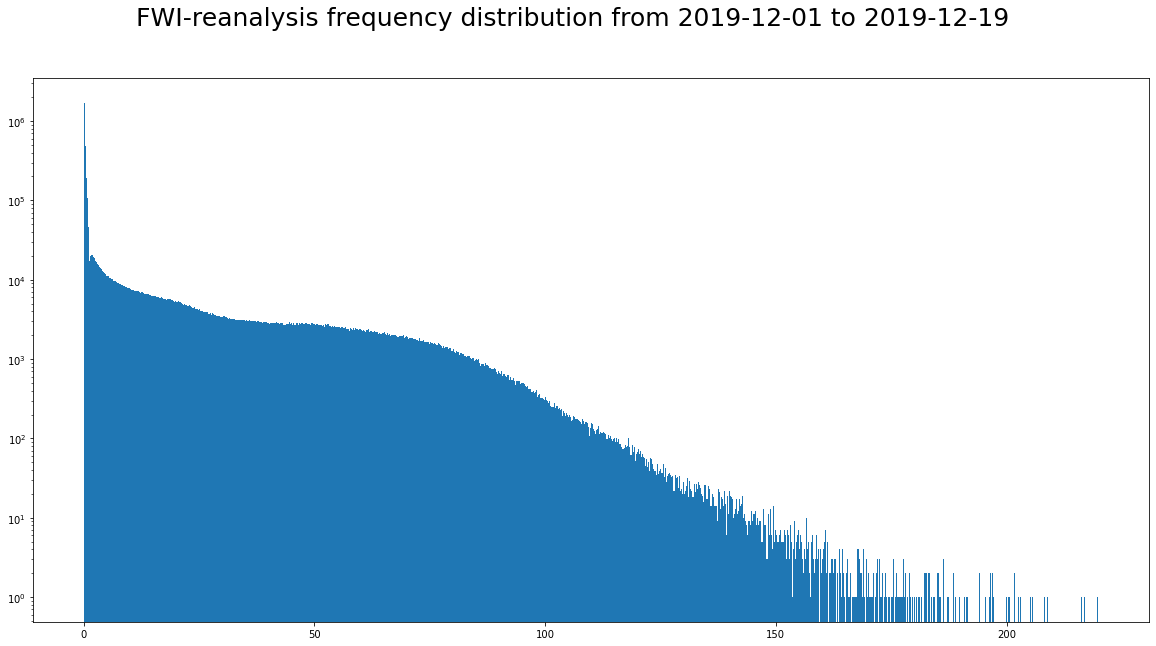

In [13]:
plt.figure(figsize = (20,10)).suptitle(f"FWI-reanalysis frequency distribution from {min(d_range)} to {max(d_range)}", fontsize=25)
plt.hist(data.fwi.values[~np.isnan(data.fwi.values)].flatten(), bins=1000, log=True);

## Box-Cox transformation

In [14]:
boxcox_fwi, _ = boxcox(data.fwi.values[~np.isnan(data.fwi.values)])

/home/anurag/miniconda3/envs/wildfire-dl/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


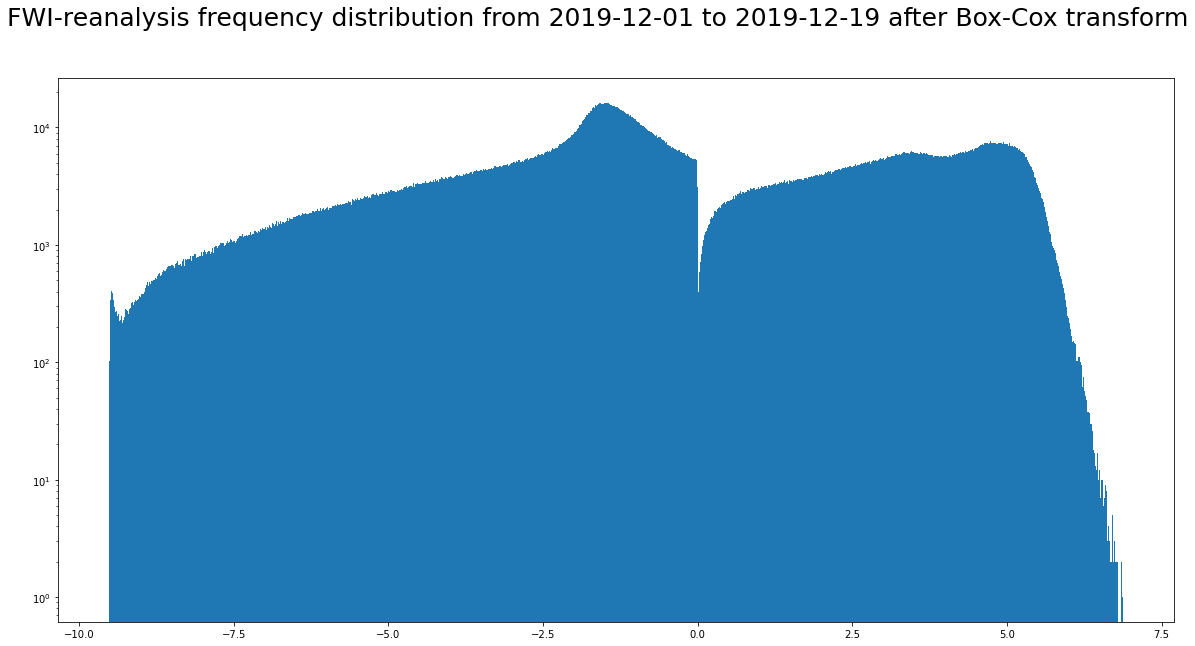

In [15]:
plt.figure(figsize = (20,10)).suptitle(f"FWI-reanalysis frequency distribution from {min(d_range)} to {max(d_range)} after Box-Cox transform", fontsize=25)
plt.hist(boxcox_fwi, bins=1000, log=True);

Statistics for Box-Cox transformed FWI,

In [16]:
npstats(boxcox_fwi)

Mean       -0.31222898
MAD        2.8504014
Variance   11.787554
Minimum    -9.520553
Maximum    6.8775373
